In [232]:
from medigraph.data.abide import AbideData
import numpy as np
from nilearn import plotting
from medigraph.model.gcn import GCN, SparseGCN, ChebGCN
from medigraph.model.baseline import DenseNN
import torch
from tqdm.notebook import tqdm
from medigraph.data.preprocess import sanitize_data, visual_sanity_check_input, whiten
from medigraph.data.experiences_data import get_training_dict_exp1, get_training_dict_exp2
from medigraph.train import training_loop, train, plot_learning_curves, test
from medigraph.data.properties import INPUTS, LABELS, TRAIN_MASK, VAL_MASK, TEST_MASK, ADJ
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [233]:
dat = AbideData()

### Check connectivy matrix for a single patient
- 111x111 matrices
- We'll retrieve the $6216=\frac{111*(111+1)}{2}$ raw coefficients from the upper triangular matrix

C:\Users\INES\Documents\3A_MVA\Geometric Data Analysis\sprectral_graph_convolutions\src\medigraph\data\abide.py:58: RuntimeWarning: divide by zero encountered in arctanh
  


input feature vector shape: (6216,)


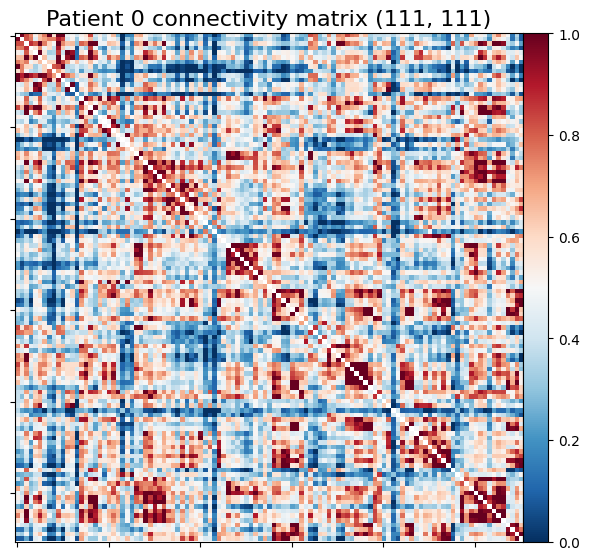

In [230]:
# Get the connectivity matrix for the first subject
idx = 0
mat = dat.get_connectivity_matrix(idx)
plotting.plot_matrix(
    mat,
    figure=(6, 6),
    vmax=1,
    vmin=0,
    title=f"Patient {idx} connectivity matrix {mat.shape}"
)
feature_vector_input = dat.get_connectivity_features(idx)
print(f"input feature vector shape: {feature_vector_input.shape}")

# Train classifier

### Build adjacency, features matrix and classification labels

In [16]:
# % Build adjacency matrix and input feature vectors
inp_np, lab_np, adj_np = dat.get_training_data()
print(f"Adjacency matrix : {adj_np.shape} [VxV]")
print(f"Labels {lab_np.shape} : [V]")
print(f"Input feature vector {inp_np.shape} : [VxF]")

Adjacency matrix : (871, 871) [VxV]
Labels (871,) : [V]
Input feature vector (871, 6216) : [VxF]


In [17]:
# % Load data to GPU
labels_np = dat.get_labels()
adj = torch.tensor(adj_np, dtype=torch.float32).to(device)
inp_raw = torch.tensor(inp_np, dtype=torch.float32).to(device)  # [V=871,  F6216]
lab = torch.tensor(labels_np, dtype=torch.float32).to(device)  # for binary classification

In [18]:
# % Sanitize and whiten data
clean_inp = sanitize_data(inp_raw)
inp = whiten(clean_inp)
inp.shape, adj.shape, lab.shape

(torch.Size([871, 6105]), torch.Size([871, 871]), torch.Size([871]))

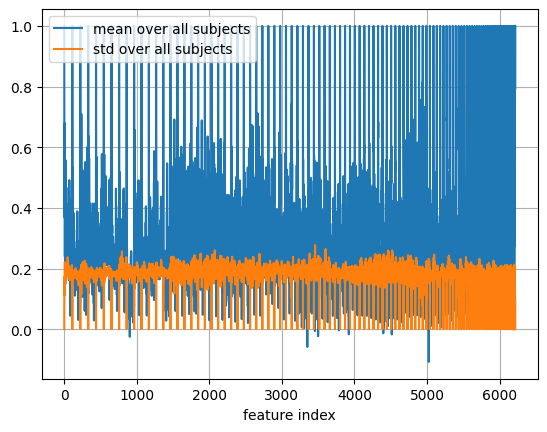

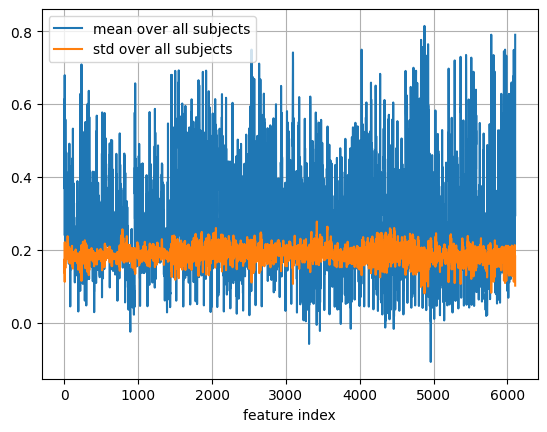

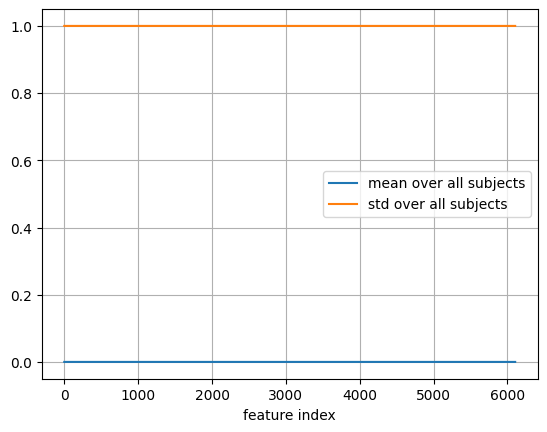

In [19]:
# % Visalization of sanity check
visual_sanity_check_input(inp_raw)
visual_sanity_check_input(clean_inp)
visual_sanity_check_input(inp)

In [ ]:
# % sanity check on graph adjacency matrix
model = GCN(inp.shape[1], adj, hdim=64)
plotting.plot_matrix(
    model.adj.detach().cpu().numpy(),
    figure=(6, 6),
    vmax=0.005,
    vmin=0,
    title=f"Graph normalized adjacency matrix {mat.shape}"
)
del model

In [ ]:
training_data = {
    INPUTS: inp,
    LABELS: lab
}
metric_dict = {}
for model_name in ["Dense", "GCN"]:
    if model_name == "GCN":
        model = GCN(inp.shape[1], adj, hdim=64)
    else:
        model = DenseNN(inp.shape[1], hdim=64)
    model.to(device)

    model, metrics = training_loop(model, training_data, device, n_epochs=1000)
    metric_dict[model_name] = metrics

In [ ]:
def plot_metrics(metric_dict: dict):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    for model_name, metric in metric_dict.items():
        print(metric.keys())
        axs[0].plot(metric["training_losses"], label=model_name)
        axs[1].plot(metric["training_accuracies"], label=f"{model_name} accuracy")
    for ax in axs:
        ax.legend()
        ax.grid()
    axs[0].set_title("Training loss (Binary Cross Entropy)")
    axs[1].set_title("Accuracy")

    plt.show()


plot_metrics(metric_dict)

---

## Exp 1 : Train classifiers without reduction of features

Here we trained the classifier on all the features (using the 'sanitizer made by Balthazar')


In [260]:
training_dict_exp1 = get_training_dict_exp1(dat, nb_train=700, nb_val=100, override=False)
# put to tensor and to device
training_dict_exp1[TRAIN_MASK] = torch.LongTensor(training_dict_exp1[TRAIN_MASK])
training_dict_exp1[VAL_MASK] = torch.LongTensor(training_dict_exp1[VAL_MASK])
training_dict_exp1[TEST_MASK] = torch.LongTensor(training_dict_exp1[TEST_MASK])
training_dict_exp1[INPUTS] = torch.tensor(training_dict_exp1[INPUTS], dtype=torch.float32).to(device)
training_dict_exp1[LABELS] = torch.tensor(training_dict_exp1[LABELS], dtype=torch.float32).unsqueeze(1).to(device)


in_channels_exp1 = training_dict_exp1[INPUTS].shape[1]

Metadata mask: 100%|██████████| 871/871 [03:14<00:00,  4.49it/s]


Understand and visualize the feature (reflection to add to the report ?)

plot the correlation matrix, visualize with PCA or with UMAP ?

### Baseline : DenseNN

In [201]:
DenseNN_exp1 = DenseNN(in_channels_exp1,
                       hdim=64)

In [202]:
if training_dict_exp1[LABELS].ndim > 1:
    training_dict_exp1[LABELS] = training_dict_exp1[LABELS].squeeze(1)
DenseNN_exp1, DenseNN_exp1_train_log, DenseNN_exp1_val_log = train(DenseNN_exp1, 
                                                                   training_dict_exp1,
                                                                   nEpochs=200,
                                                                   optimizer_params={'lr': 0.001, 
                                                                                     'weight_decay': 0.05})

Training: 100%|██████████| 200/200 [00:06<00:00, 32.10it/s]


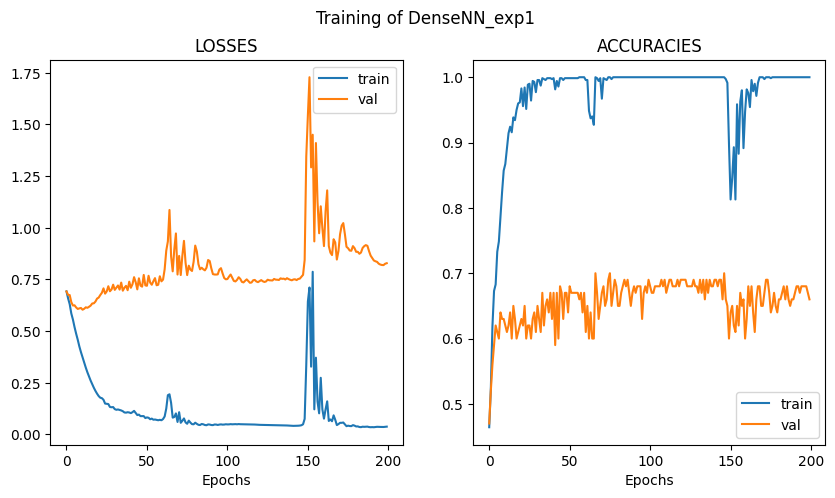

In [203]:
plot_learning_curves(DenseNN_exp1_train_log, DenseNN_exp1_val_log, title="Training of DenseNN_exp1")

In [204]:
# Testing 
loss_test, acc_test = test(DenseNN_exp1, training_dict_exp1)
print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test loss: 0.8000, Test accuracy: 0.6620


### GCN 

In [261]:
if training_dict_exp1[LABELS].ndim == 1:
    training_dict_exp1[LABELS] = training_dict_exp1[LABELS].unsqueeze(1)

GCN_exp1 = SparseGCN(in_channels_exp1, 
                  nhid=[256, 128], 
                  nclass=1, 
                  adjacency=training_dict_exp1[ADJ], 
                  proba_dropout=0.6)

in_feat 6105 out_feat 256
in_feat 256 out_feat 128
in_feat 128 out_feat 1


In [262]:
GCN_exp1, GCN_exp1_train_log, GCN_exp1_val_log = train(GCN_exp1, training_dict_exp1, 
                                              nEpochs=200, 
                                              optimizer_params={'lr': 0.01, 'weight_decay': 0.05})
# torch.save(GCN_exp1.state_dict(), "__GCN_exp1")

Training: 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


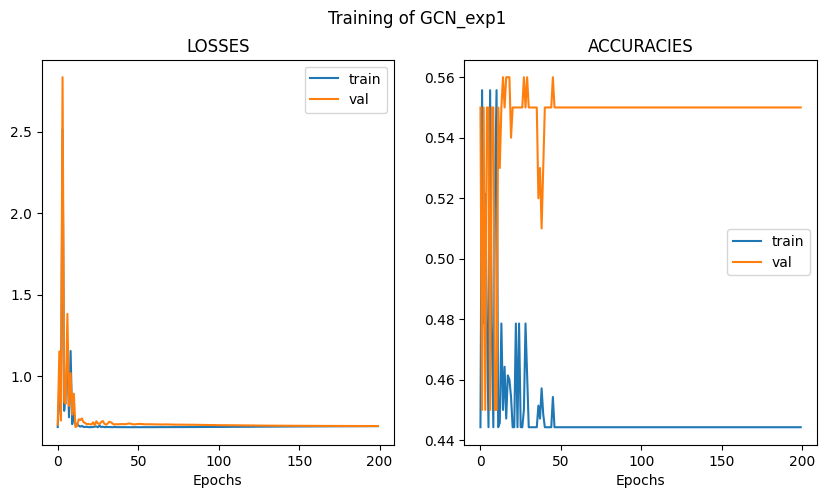

In [263]:
plot_learning_curves(GCN_exp1_train_log, GCN_exp1_val_log, title="Training of GCN_exp1")

In [264]:
# Testing 
loss_test, acc_test = test(GCN_exp1, training_dict_exp1)
print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test loss: 0.6917, Test accuracy: 0.5211


### ChebGCN on exp1
TO DO

---

## Exp 2 : Train classifiers with selected feat

Here, we train the same network with features reduced by a ridge classifier

In [242]:
training_dict_exp2 = get_training_dict_exp2(dat, nb_train=700, nb_val=100, override=False)
# put to tensor and to device
training_dict_exp2[TRAIN_MASK] = torch.LongTensor(training_dict_exp2[TRAIN_MASK])
training_dict_exp2[VAL_MASK] = torch.LongTensor(training_dict_exp2[VAL_MASK])
training_dict_exp2[TEST_MASK] = torch.LongTensor(training_dict_exp2[TEST_MASK])
training_dict_exp2[INPUTS] = torch.tensor(training_dict_exp2[INPUTS], dtype=torch.float32).to(device)
training_dict_exp2[LABELS] = torch.tensor(training_dict_exp2[LABELS], dtype=torch.float32).unsqueeze(1).to(device)

in_channels_exp2 = training_dict_exp2[INPUTS].shape[1]

Metadata mask: 100%|██████████| 871/871 [03:52<00:00,  3.75it/s]


Understand and visualize the data to compare with the precedent experience 

Correlation matrix, PCA, UMAP ? 

In [244]:
# PCA : TO DO

# selected_feat = get_training_dict_exp2[INPUTS]
# print(selected_feat.shape)

### Baseline : DenseNN

In [245]:
DenseNN_exp2 = DenseNN(in_channels_exp2,
                       hdim=64)

In [246]:
if training_dict_exp2[LABELS].ndim > 1:
    training_dict_exp2[LABELS] = training_dict_exp2[LABELS].squeeze(1)
DenseNN_exp2, DenseNN_exp2_train_log, DenseNN_exp2_val_log = train(DenseNN_exp2, 
                                                                   training_dict_exp2,
                                                                   nEpochs=200,
                                                                   optimizer_params={'lr': 0.001, 
                                                                                     'weight_decay': 0.05})

Training: 100%|██████████| 200/200 [00:02<00:00, 76.30it/s]


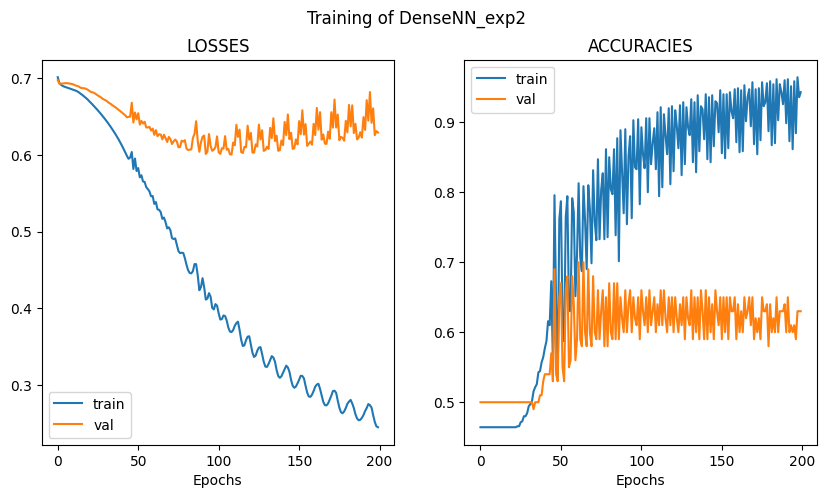

In [247]:
plot_learning_curves(DenseNN_exp2_train_log, DenseNN_exp2_val_log, title="Training of DenseNN_exp2")

In [248]:
# Testing 
loss_test, acc_test = test(DenseNN_exp2, training_dict_exp2)
print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test loss: 0.6605, Test accuracy: 0.6901


### GCN

In [249]:
if training_dict_exp2[LABELS].ndim == 1:
    training_dict_exp2[LABELS] = training_dict_exp2[LABELS].unsqueeze(1)

GCN_exp2 = SparseGCN(in_channels_exp2, 
                  nhid=[128, 64], 
                  nclass=1, 
                  adjacency=training_dict_exp2[ADJ], 
                  proba_dropout=0.3)

in_feat 2000 out_feat 128
in_feat 128 out_feat 64
in_feat 64 out_feat 1


In [250]:
# Testing  before training to see if the model get better
loss_test, acc_test = test(GCN_exp2, training_dict_exp2)
print(f"Test Before Training \n loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test Before Training 
 loss: 0.6727, Test accuracy: 0.3944


In [251]:
# training_dict_exp2[LABELS] = training_dict_exp2[LABELS].squeeze(1)
GCN_exp2, GCN_exp2_train_log, GCN_exp2_val_log = train(GCN_exp2, training_dict_exp2, 
                                              nEpochs=200, 
                                              optimizer_params={'lr': 0.001, 'weight_decay': 0.005})
# torch.save(trained_model_GCN.state_dict(), "__trained_model_GCN")

Training: 100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


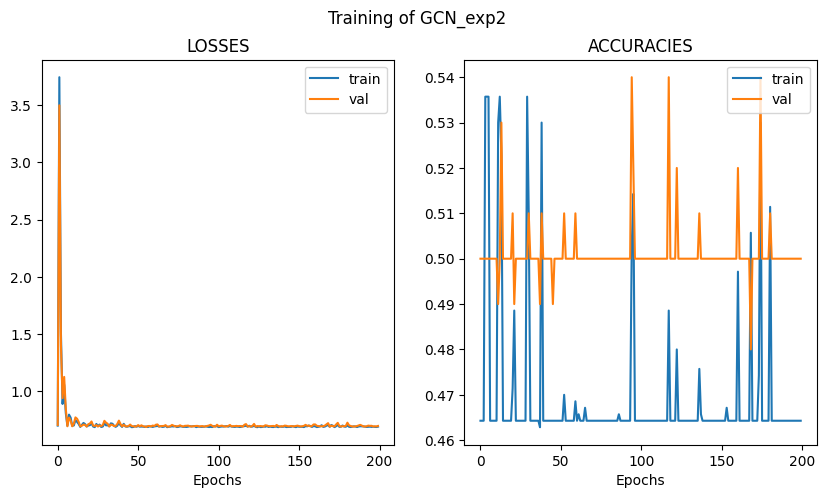

In [252]:
plot_learning_curves(GCN_exp2_train_log, GCN_exp2_val_log, title="Training of GCN_exp2")

In [253]:
np.unique(GCN_exp2_val_log["accuracies"])

array([0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54])

In [254]:
# Testing after training
loss_test, acc_test = test(GCN_exp2, training_dict_exp2)
print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test loss: 0.6755, Test accuracy: 0.3944


### ChebConv

In [255]:
ChebGCN_exp2 = ChebGCN(in_channels_exp2, out_features=1, K=3,
                       adjacency=training_dict_exp2[ADJ],
                       proba_dropout=0.3)

In [256]:
ChebGCN_exp2, ChebGCN_exp2_train_log, ChebGCN_exp2_val_log = train(ChebGCN_exp2, training_dict_exp2,
                                            nEpochs=200,
                                            optimizer_params={'lr': 0.005, 'weight_decay': 0.005})

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training: 100%|██████████| 200/200 [22:27<00:00,  6.74s/it]


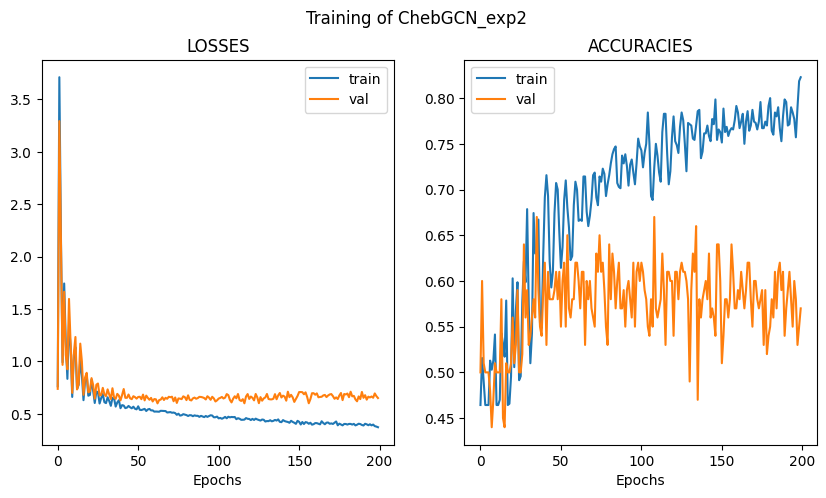

In [257]:
plot_learning_curves(ChebGCN_exp2_train_log, ChebGCN_exp2_val_log, title="Training of ChebGCN_exp2")

In [259]:
# Testing
loss_test, acc_test = test(ChebGCN_exp2, training_dict_exp2)
print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {acc_test.item():.4f}")

=== Computing metrics on 71 test nodes ===
Test loss: 0.6553, Test accuracy: 0.6620
